the basis of this code is taken from sean o' toole's code in matlab, i just took it where it looked at 3 configurations and updated it to look at this grid set of configurations to 

get a PIO value for any configuration. i first took his matlab code and transferred it to python and with the exact same data points

got the same exact graphs as his. thus validating that this code is properly executed

# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import mean_squared_error
import math
import matlab.engine

# Import Data

variables listed with a 1 are from the grid of

    tld: 0->1 
    
    tlg: 1->2

    tau: 0->1

    kp: 0->1

variables listed with a 2 are from the grid of

    tld: 0->1 
    
    tlg: 0.5->1

    tau: 0->1

    kp: 0->1

we will take the data from variable 1 and data from variable 2 and then concat together thus we have data that covers the entire grid

In [2]:
file_path = r"C:\Users\steph\OneDrive\Desktop\Stephen\ADCL\thesis stuff\ALL THESIS DATA\PIO data\large data to create grid_thirdorder_1\params.csv"
params_1 = pd.read_csv(file_path,header=None).to_numpy()           #pd.read_csv('params_pio_5_10.csv',header = None).to_numpy()

file_path = r"C:\Users\steph\OneDrive\Desktop\Stephen\ADCL\thesis stuff\ALL THESIS DATA\PIO data\large data to create grid_thirdorder_1\pitchcmd.csv"
pitchcmd_1 = pd.read_csv(file_path,header=None).to_numpy()         #pd.read_csv('pitchcmd_pio_5_10.csv').to_numpy().T[0,:] * (180/math.pi) # Only need 1 pitchcmd run bc they are all the same

file_path = r"C:\Users\steph\OneDrive\Desktop\Stephen\ADCL\thesis stuff\ALL THESIS DATA\PIO data\large data to create grid_thirdorder_1\pitchoutput.csv"
pitchoutput_1 = pd.read_csv(file_path,header=None).to_numpy()         #pd.read_csv('pitchoutput_pio_5_10.csv').to_numpy().T * (180/math.pi)

file_path = r"C:\Users\steph\OneDrive\Desktop\Stephen\ADCL\thesis stuff\ALL THESIS DATA\PIO data\large data to create grid_thirdorder_2\params_2.csv"
params_2 = pd.read_csv(file_path, header=None).to_numpy()

pitchcmd_2 = pitchcmd_1

Ts = 0.01
Tfinal = 10
length = Tfinal/Ts
time = np.arange(0, Tfinal, Ts)

# Check shapes make sense
pitchoutput_1.shape

(1001, 11000)

In [3]:
file_path = r"C:\Users\steph\OneDrive\Desktop\Stephen\ADCL\thesis stuff\ALL THESIS DATA\PIO data\large data to create grid_thirdorder_2\pitchoutput_2.csv"
pitchoutput_2 = pd.read_csv(file_path,header=None).to_numpy()

pitchoutput_2.shape

(1001, 6000)

In [4]:
pitchcmd_1 = pitchcmd_1.T[0,:] * (180/math.pi)
pitchcmd_2 = pitchcmd_2.T[0,:] * (180/math.pi)

In [5]:
pitchoutput_1 = pitchoutput_1.T * (180/math.pi)
pitchoutput_2 = pitchoutput_2.T * (180/math.pi)

In [6]:
pitchoutput_1.shape, pitchoutput_2.shape

((11000, 1001), (6000, 1001))

In [7]:
pitchoutput_1.shape, pitchoutput_2.shape

((11000, 1001), (6000, 1001))

In [8]:
pitchcmd_1[-1]

4.999973494988642

In [9]:
params = np.vstack((params_1, params_2))
params.shape

(17000, 4)

In [10]:
pitchcmd = np.vstack((pitchcmd_1))
pitchoutput = np.vstack((pitchoutput_1, pitchoutput_2))
pitchcmd.shape, pitchoutput.shape

((1001, 1), (17000, 1001))

# Data Preperation

### Filter out data that doesn't even reach the target value

use all of the pitch tracking data and apply the step tracking criterion steps

1-find time where angle=pipper error this is D

2-find the rmse after D

3-if the response is so slow that it doesnt even reach the pipper error then omit it

we do this for every run

In [11]:
D_log = []
rmse_log = []
delete_log = []

# Step size in degrees
step_size = pitchcmd[-1]

# Compute the target value
target_value = step_size - (1 / 40) * step_size

# Define the tolerance
tolerance = 1e-1  # Adjust tolerance as needed

for i in range(len(pitchoutput)):
  # Find the indices where the absolute difference is within the tolerance
  indices_within_tolerance = np.where(np.abs(pitchoutput[i,:] - target_value) <= tolerance)[0]
  # Get the first index within the tolerance
  if indices_within_tolerance.size > 0:
    first_index = indices_within_tolerance[0]
    D = time[first_index]-0.25
    D_log.append(D)

    rmse = np.sqrt(mean_squared_error(pitchoutput[i,:][first_index:], pitchcmd[first_index:]))
    rmse_log.append(rmse)
  else:
    #print(f"No values found within the specified tolerance: {i}.")
    delete_log.append(i)
np.array(D_log).shape, np.array(rmse_log).shape, np.array(delete_log).shape

((16952,), (16952,), (48,))

In [12]:
# Create a boolean mask for rows to keep
mask = np.ones(params.shape[0], dtype=bool)  # Initialize mask with True (keep all rows)
mask[np.array(delete_log)] = False  # Set rows to delete as False in the mask

# Use the mask to filter the original array
filtered_params = params[mask]

filtered_params.shape

(16952, 4)

In [ ]:
D_array = np.array(D_log) #np.array([D_1, D_2, D_3, D_4, D_5])
rmse_array = np.array(rmse_log) #np.array([rmse1, rmse2, rmse3, rmse4, rmse5])
#filtered_params = params


filtered_params.shape, D_array.shape, rmse_array.shape

((16952, 4), (16952,), (16952,))

# Compute PIO criterion Values

this is the part that is the same as sean o'tooles matlab code except in python

In [14]:
# Compute the finite difference approximations
def finite_difference_second_derivative(x, y):
    # Ensure x and y are numpy arrays
    x = np.asarray(x)
    y = np.asarray(y)

    # First derivatives
    dy_dx = np.diff(y) / np.diff(x)

    # Second derivatives
    d2y_dx2 = np.diff(dy_dx) / np.diff(x[:-1])  # We use x[:-1] to match the length of dy_dx

    return d2y_dx2

# Calculate PIO metrics
pio_values = np.abs(finite_difference_second_derivative(D_array, rmse_array))

C:\Users\steph\AppData\Local\Temp\ipykernel_12112\1053153346.py:8: RuntimeWarning: divide by zero encountered in divide
  dy_dx = np.diff(y) / np.diff(x)
C:\Users\steph\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:1448: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


after the double derivative we can get some nans and infs so we will omit those from the data

### Fill in INF values

In [15]:
inf_indices = np.where(np.isinf(pio_values))[0]
pio_values_no_infs = np.delete(pio_values, inf_indices)
D_array_no_infs = np.delete(D_array, inf_indices+1)
params_no_infs = np.delete(filtered_params, inf_indices+1, axis=0)
rmse_array_no_infs = np.delete(rmse_array, inf_indices+1)

### Fill in NAN values

In [16]:
# Step 1: Create a boolean mask for rows with NaN values
nan_mask = np.isnan(pio_values_no_infs)
# Get the indices of NaN values
nan_indices = np.where(nan_mask)

# Step 2: Use the mask to filter out rows with NaN values
pio_values_noinfnan = np.delete(pio_values_no_infs, nan_indices)
D_array_noinfnan = np.delete(D_array_no_infs, np.array(nan_indices)+1)
params_noinfnan = np.delete(params_no_infs, np.array(nan_indices)+1, axis=0)
rmse_array_noinfnan = np.delete(rmse_array_no_infs, np.array(nan_indices)+1)

In [17]:
params_noinfnan.shape

(12852, 4)

In [18]:
D_array_noinfnan.shape, pio_values_noinfnan.shape

((12852,), (12850,))

### Plot the PIO values

C:\Users\steph\AppData\Local\Temp\ipykernel_12112\3399154598.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "xb" (-> color='b'). The keyword argument will take precedence.
  plt.plot(D_array_noinfnan[i+1],pio_values_noinfnan[i], 'xb', c = colors[np.random.randint(0, 5)])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


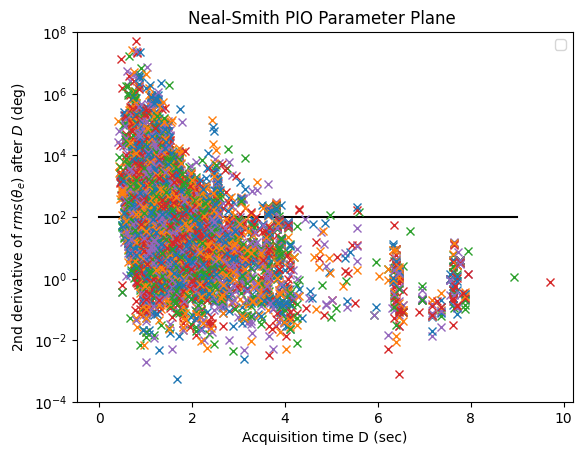

In [19]:
# PIO boundary and axis settings
PIO_prone = [100, 100]  # Boundary line for PIO-prone region
x_6 = [0, 9] #[0, 2.5]  # Corresponding x-axis range for PIO_prone


# PIO parameter plane plot
plt.figure()
colors = ['blue', 'purple', 'orange', 'red', 'green']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.plot(x_6, PIO_prone, 'k', linewidth=1.5)  # Boundary line

'''
for i in range(len(D_array_noinfnan[1:-1])):
  if pio_values_noinfnan[i] == pio_values_noinfnan.max():
    label = r'$T_{{Lead}}: {:.2f}, T_{{Lag}}: {:.2f}, \tau: {:.2f}, K_{{p}}: {:.2f}$'.format(params_noinfnan[i+1, 0], params_noinfnan[i+1, 1], params_noinfnan[i+1, 2], params_noinfnan[i+1, 3])
    plt.plot(D_array_noinfnan[i+1],pio_values_noinfnan[i], '*b', c = 'red', label = label, markersize=15)
    tld_max, tlg_max, tau_max, kp_max = params_noinfnan[i+1, 0], params_noinfnan[i+1, 1], params_noinfnan[i+1, 2], params_noinfnan[i+1, 3]
  elif pio_values_noinfnan[i] == pio_values_noinfnan.min():
    label = r'$T_{{Lead}}: {:.2f}, T_{{Lag}}: {:.2f}, \tau: {:.2f}, K_{{p}}: {:.2f}$'.format(params_noinfnan[i+1, 0], params_noinfnan[i+1, 1], params_noinfnan[i+1, 2], params_noinfnan[i+1, 3])
    plt.plot(D_array_noinfnan[i+1],pio_values_noinfnan[i], '*b', c = 'green', label = label, markersize=15)
    tld_min, tlg_min, tau_min, kp_min = params_noinfnan[i+1, 0], params_noinfnan[i+1, 1], params_noinfnan[i+1, 2], params_noinfnan[i+1, 3]
  else:
    plt.plot(D_array_noinfnan[i+1],pio_values_noinfnan[i], 'xb', c = colors[np.random.randint(0, 9)])
'''


for i in range(len(D_array_noinfnan[1:-1])):
  plt.plot(D_array_noinfnan[i+1],pio_values_noinfnan[i], 'xb', c = colors[np.random.randint(0, 5)])

  
#or use this code to plot
#plt.plot(DD[1:-1], pioSS, 'xb')  # Blue 'x' markers for SS
#plt.text(5, 150, 'PIO-Prone')
#plt.text(5, 40, 'PIO-Immune')
plt.title('Neal-Smith PIO Parameter Plane ')
#plt.grid(True)
#plt.xlabel('Acquisition time D (sec)\nNLDI (red)     Stick-to-Servo (blue)')
plt.xlabel('Acquisition time D (sec)')
plt.ylabel(r'2nd derivative of $rms(\theta_e)$ after $D$ (deg)')
plt.yscale('log')
plt.ylim([10**-4, 10**8])
#plt.xlim([0, 5])
#plt.xlim([1, 2.5])
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [20]:
D_array_noinfnan[1:-1].shape, pio_values_noinfnan.shape, params_noinfnan[1:-1].shape, rmse_array_noinfnan[1:-1].shape

((12850,), (12850,), (12850, 4), (12850,))

In [21]:
# Count elements greater than 100
above_100 = np.sum(pio_values_noinfnan > 100)

# Count elements less than or equal to 100
below_or_equal_100 = np.sum(pio_values_noinfnan <= 100)

above_100, below_or_equal_100

(3892, 8958)

## sample pio calculation to see effect of tau+0.3 seconds has

In [22]:
# The target row you want to find
tld = 0.8
tlg = 1.8
tau = 0.3
kp = 0.5
target_row_1 = np.array([tld, tlg, tau, kp])

# Find the index of the row where all elements match the target row
row_index_1 = np.where(np.all(params_noinfnan[1:-1] == target_row_1, axis=1))[0]
row_index_1, pio_values_noinfnan[row_index_1]

(array([1925], dtype=int64), array([0.95575888]))

In [23]:
# The target row you want to find
target_row_2 = np.array([tld,tlg, tau+0.3,kp])

# Find the index of the row where all elements match the target row
row_index_2 = np.where(np.all(params_noinfnan[1:-1] == target_row_2, axis=1))[0]
row_index_2, pio_values_noinfnan[row_index_2]

(array([2243], dtype=int64), array([19.85562784]))

## plot the pio as a heatmap

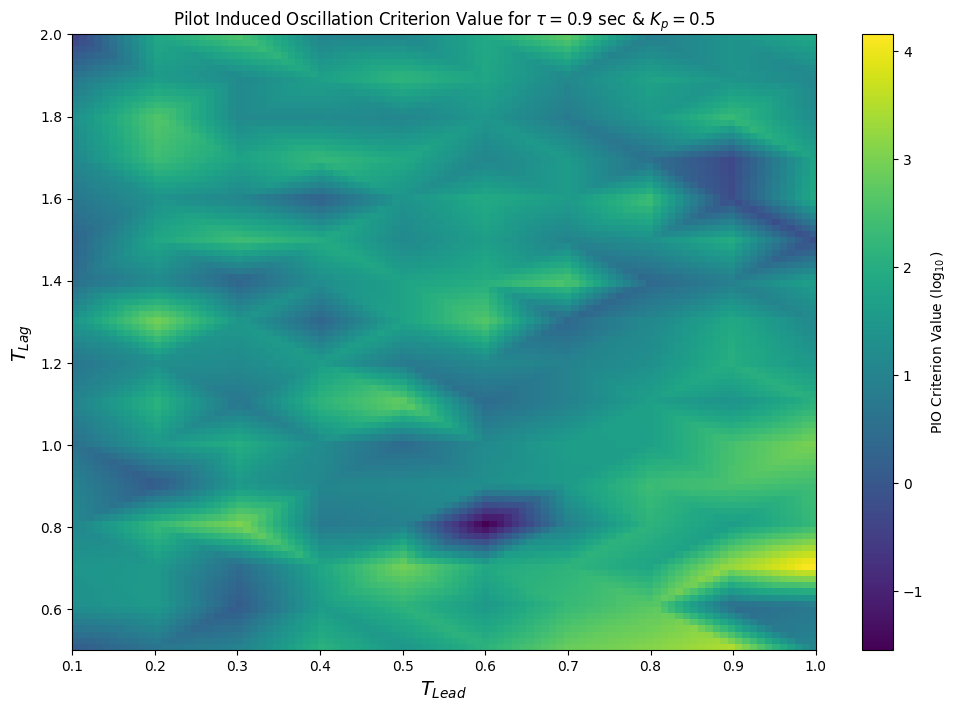

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Assuming params_noinfnan and pio_values_noinfnan are defined
tau_array = params_noinfnan[1:-1][:, 2]
number_to_find = 0.9  # Set this to any tau value you want to see
indices = np.where(tau_array == number_to_find)[0]

# Example arrays
x = params_noinfnan[1:-1][:, 0][indices]  # First array (x-coordinates)
y = params_noinfnan[1:-1][:, 1][indices]  # Second array (y-coordinates)
m = params_noinfnan[1:-1][:, 3][indices]  # Third array (m-coordinates)
z = pio_values_noinfnan[indices]  # Fourth array (z-values for the surface)
z = np.log10(z)  # Convert z to logarithmic scale

# Filter out NaN and inf values
mask = ~np.isnan(z) & ~np.isinf(z)
x = x[mask]
y = y[mask]
m = m[mask]
z = z[mask]

# Create a grid for interpolation in the x-y plane
xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
xi, yi = np.meshgrid(xi, yi)

# Choose a fixed value of m for the heatmap
fixed_m = 0.5  # This is Kp; you can choose another value based on your data

# Interpolate z values onto the grid for the fixed value of m
zi = griddata((x, y, m), z, (xi, yi, fixed_m), method='linear')

# Plot the heatmap using imshow
plt.figure(figsize=(12, 8))
heatmap = plt.imshow(zi, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='viridis', aspect='auto')

# Add color bar for the heatmap
plt.colorbar(heatmap, label='PIO Criterion Value ($\log_{10}$)')

# Set labels
plt.xlabel('$T_{Lead}$', fontsize=14)
plt.ylabel('$T_{Lag}$', fontsize=14)
plt.title(f'Pilot Induced Oscillation Criterion Value for $\\tau = {number_to_find}$ sec & $K_p = {fixed_m}$')

'''
x1 = 0.4
x2 = 0.4
y1 = 1.1
y2 = 1.6
plt.scatter(x1,y1, color='red', s=50, label='$t_{1}$')
plt.scatter(x1,y2, color='orange', s=50, label='$t_{2}$')
plt.quiver(x1, y1,
          x2 - x1, y2 - y1,
          angles='xy', scale_units='xy', scale=1.02, 
          color='black', linewidth=1)

# Add a legend for the points
plt.legend()
'''

plt.show()


## plot the pio as a heatmap except change the colors to reds and greens

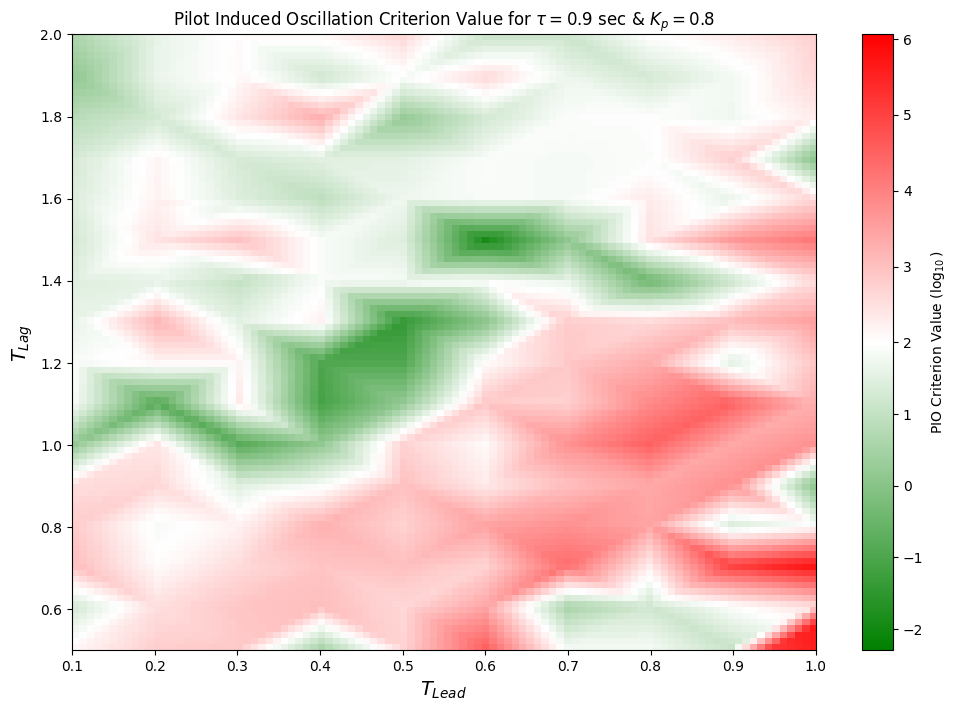

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.colors as mcolors

# Assuming params_noinfnan and pio_values_noinfnan are defined
tau_array = params_noinfnan[1:-1][:, 2]
number_to_find = 0.9  # Set this to any tau value you want to see
indices = np.where(tau_array == number_to_find)[0]

# Example arrays
x = params_noinfnan[1:-1][:, 0][indices]  # First array (x-coordinates)
y = params_noinfnan[1:-1][:, 1][indices]  # Second array (y-coordinates)
m = params_noinfnan[1:-1][:, 3][indices]  # Third array (m-coordinates)
z = pio_values_noinfnan[indices]  # Fourth array (z-values for the surface)
z = np.log10(z)  # Convert z to logarithmic scale

# Filter out NaN and inf values
mask = ~np.isnan(z) & ~np.isinf(z)
x = x[mask]
y = y[mask]
m = m[mask]
z = z[mask]

# Create a grid for interpolation in the x-y plane
xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
xi, yi = np.meshgrid(xi, yi)

# Choose a fixed value of m for the heatmap
fixed_m = 0.8  # This is Kp; you can choose another value based on your data

# Interpolate z values onto the grid for the fixed value of m
zi = griddata((x, y, m), z, (xi, yi, fixed_m), method='linear')

# Define the custom colormap
def custom_colormap():
    return mcolors.LinearSegmentedColormap.from_list('CustomMap', ['green', 'white', 'red'])

# Use TwoSlopeNorm to center the colormap at 100
norm = mcolors.TwoSlopeNorm(vmin=min(z), vcenter=2, vmax=max(z))

# Plot the heatmap using imshow
plt.figure(figsize=(12, 8))
heatmap = plt.imshow(zi, extent=(min(x), max(x), min(y), max(y)), origin='lower',
                     cmap=custom_colormap(), norm=norm, aspect='auto')

# Add color bar for the heatmap
plt.colorbar(heatmap, label='PIO Criterion Value ($\log_{10}$)')

# Set labels
plt.xlabel('$T_{Lead}$', fontsize=14)
plt.ylabel('$T_{Lag}$', fontsize=14)
plt.title(f'Pilot Induced Oscillation Criterion Value for $\\tau = {number_to_find}$ sec & $K_p = {fixed_m}$')

'''
x1 = 0.4
x2 = 0.4
y1 = 1.1
y2 = 1.6
plt.scatter(x1, y1, color='red', s=50, label='$t_{1}$')
plt.scatter(x1, y2, color='orange', s=50, label='$t_{2}$')
plt.quiver(x1, y1,
          x2 - x1, y2 - y1,
          angles='xy', scale_units='xy', scale=1.02, 
          color='black', linewidth=1)

# Add a legend for the points
plt.legend()
'''

plt.show()


### plot the pio heatmaps as a 3x3 subplots

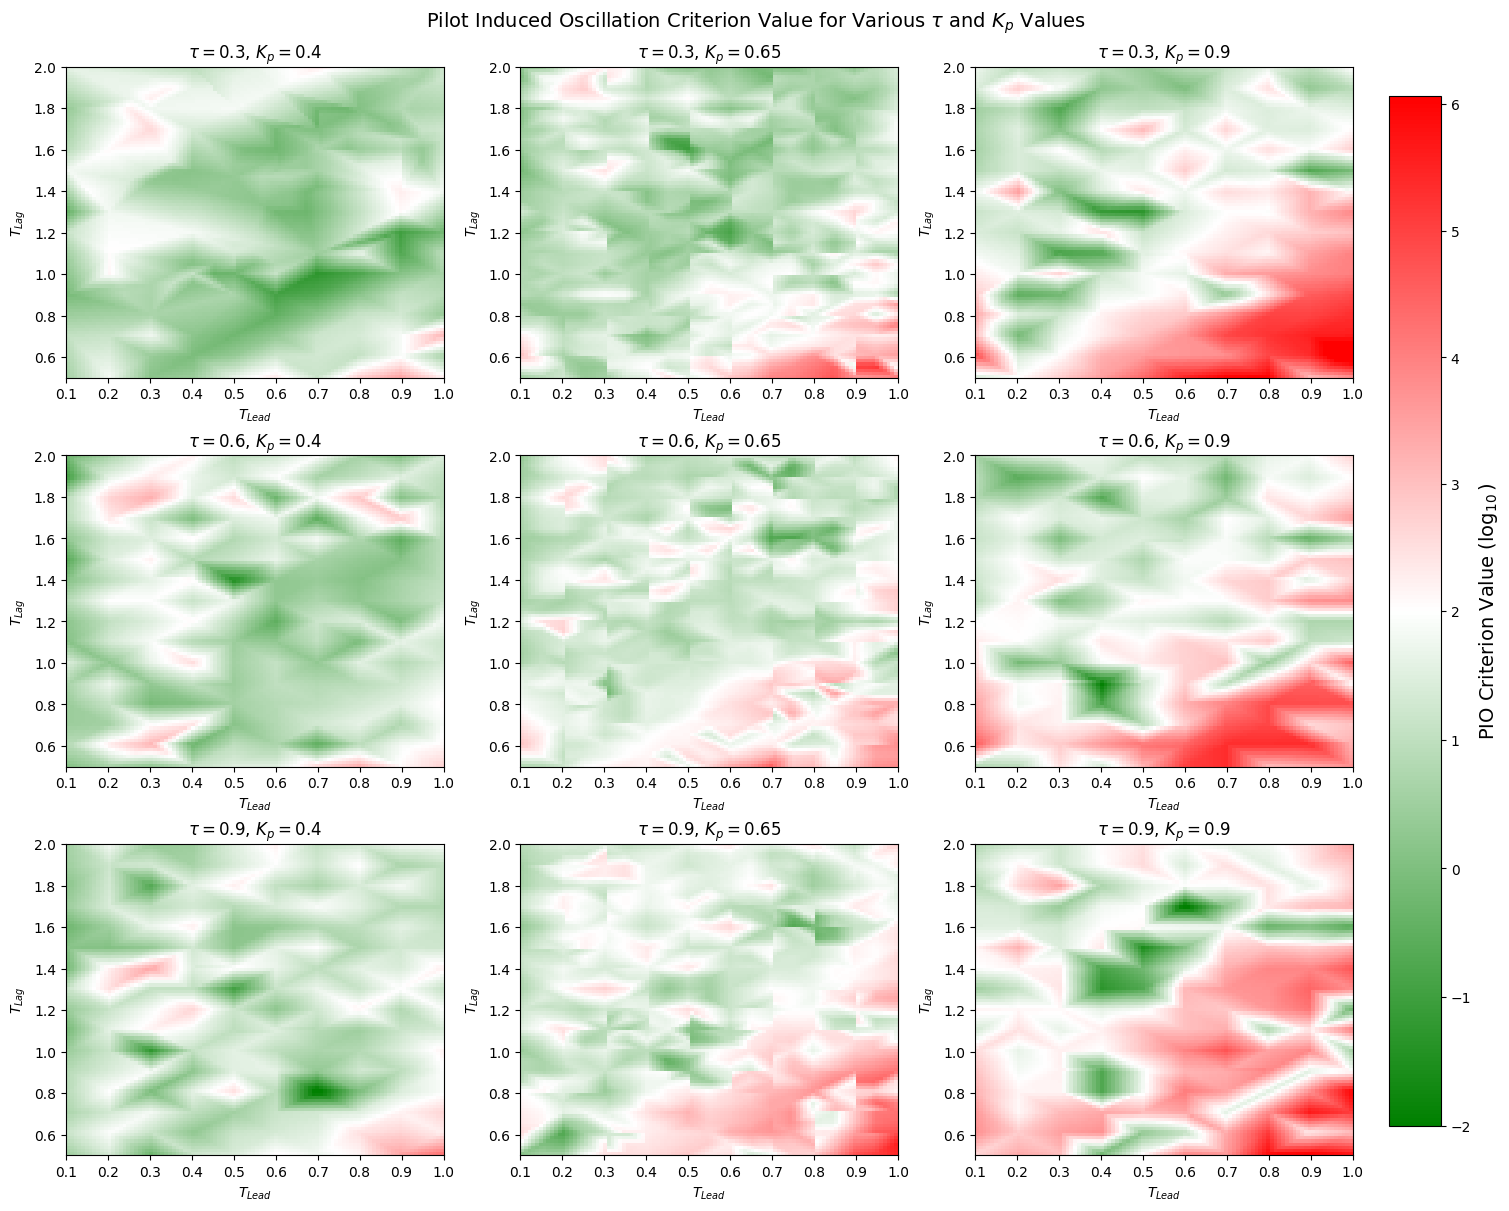

In [26]:
# make 3x3 subplot
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.colors as mcolors

# Assuming params_noinfnan and pio_values_noinfnan are defined
tau_array = params_noinfnan[1:-1][:, 2]

# Define the range of values for number_to_find (tau) and fixed_m (Kp)
number_to_find_values = [0.3, 0.6, 0.9]  # Example tau values to use
fixed_m_values = [0.4, 0.65, 0.9]         # Example Kp values to use

# Custom colormap function
def custom_colormap():
    return mcolors.LinearSegmentedColormap.from_list('CustomMap', ['green', 'white', 'red'])

# Plotting the 3x3 grid
fig, axs = plt.subplots(3, 3, figsize=(15, 12), constrained_layout=True)
norm = mcolors.TwoSlopeNorm(vmin=-2, vcenter=2, vmax=max(z))  # Adjust based on your data range

# Loop over each combination of number_to_find and fixed_m
for i, number_to_find in enumerate(number_to_find_values):
    for j, fixed_m in enumerate(fixed_m_values):
        # Filter data for current tau
        indices = np.where(tau_array == number_to_find)[0]
        
        # Extract x, y, m, and z values for plotting
        x = params_noinfnan[1:-1][:, 0][indices]  # First array (x-coordinates)
        y = params_noinfnan[1:-1][:, 1][indices]  # Second array (y-coordinates)
        m = params_noinfnan[1:-1][:, 3][indices]  # Third array (m-coordinates)
        z = pio_values_noinfnan[indices]          # Fourth array (z-values for the surface)
        z = np.log10(z)                           # Convert z to logarithmic scale

        # Filter out NaN and inf values
        mask = ~np.isnan(z) & ~np.isinf(z)
        x, y, m, z = x[mask], y[mask], m[mask], z[mask]

        # Create a grid for interpolation in the x-y plane
        xi = np.linspace(min(x), max(x), 100)
        yi = np.linspace(min(y), max(y), 100)
        xi, yi = np.meshgrid(xi, yi)

        # Interpolate z values onto the grid for the fixed value of m
        zi = griddata((x, y, m), z, (xi, yi, fixed_m), method='linear')

        # Plot each subplot
        ax = axs[i, j]
        heatmap = ax.imshow(zi, extent=(min(x), max(x), min(y), max(y)), origin='lower',
                            cmap=custom_colormap(), norm=norm, aspect='auto')
        
        # Set subplot title and labels
        ax.set_title(f'$\\tau = {number_to_find}$, $K_p = {fixed_m}$')
        ax.set_xlabel('$T_{Lead}$')
        ax.set_ylabel('$T_{Lag}$')

# Add a single color bar for all subplots
cbar = fig.colorbar(heatmap, ax=axs, orientation='vertical', fraction=0.04, pad=0.02)
cbar.set_label('PIO Criterion Value ($\log_{10}$)', fontsize = 14)

plt.suptitle('Pilot Induced Oscillation Criterion Value for Various $\\tau$ and $K_p$ Values', fontsize=14)
plt.show()

In [ ]:
# checking the shapes to make sure they all concur
pio_values_noinfnan.shape, params_noinfnan[1:-1,:].shape, D_array_noinfnan[1:-1].shape, rmse_array_noinfnan[1:-1].shape

((12850,), (12850, 4), (12850,), (12850,))

# create KNN model for pio value estimation

we will focus on pio estimation around specific area of the domain

In [28]:
# Apply mask to x, y, and z
mask = (D_array_noinfnan[1:-1] >= 0)  & (D_array_noinfnan[1:-1] <= 4) & (pio_values_noinfnan > 1) & (pio_values_noinfnan < 10000)
D_array_filtered = D_array_noinfnan[1:-1][mask]
pio_values_filtered = pio_values_noinfnan[mask]
params_filtered = params_noinfnan[1:-1,:][mask, :]  # Apply mask to rows of z
rmse_array_filtered = rmse_array_noinfnan[1:-1][mask]
D_array_filtered.shape, pio_values_filtered.shape, params_filtered.shape, rmse_array_filtered.shape

((10936,), (10936,), (10936, 4), (10936,))

In [29]:
rmse_array_filtered = rmse_array_noinfnan[1:-1][mask]
rmse_array_filtered.shape

(10936,)

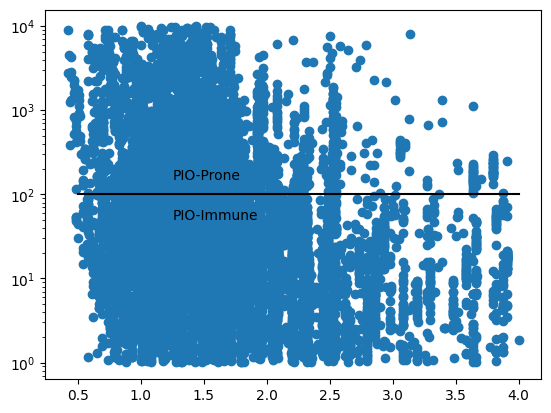

In [30]:
plt.scatter(D_array_filtered, pio_values_filtered)
# PIO boundary and axis settings
PIO_prone = [100, 100]  # Boundary line for PIO-prone region
x_6 = [0.5, 4] #[0, 2.5]  # Corresponding x-axis range for PIO_prone
plt.text(1.25, 150, 'PIO-Prone')
plt.text(1.25, 50, 'PIO-Immune')
plt.plot(x_6, PIO_prone, 'k', linewidth=1.5)  # Boundary line
plt.yscale('log')

### setup the data for the KNN

In [31]:
X = params_filtered
y = pio_values_filtered
D = D_array_filtered
rmse = rmse_array_filtered
X.shape, y.shape
# Convert y_test to a DataFrame
df = pd.DataFrame({
    'prone_or_immune': np.where(y > 100, 1, 0)
})
df.value_counts()

prone_or_immune
0                  7640
1                  3296
Name: count, dtype: int64

In [32]:
X.shape, D.shape, rmse.shape

((10936, 4), (10936,), (10936,))

### train the KNN

In [33]:
# try making a KNN Model

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Split the data into training and test sets
X_train, X_test, y_train, y_test, D_train, D_test = train_test_split(X, y, D, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the KNN regressor with k=8 neighbors
knn_regressor = KNeighborsRegressor(n_neighbors=8, weights='distance')

# Fit the model to the scaled training data
knn_regressor.fit(X_train_scaled, y_train)

# Make predictions on the scaled test set
y_pred = knn_regressor.predict(X_test_scaled)

# Calculate the Mean Squared Error (MSE) and Mean Absolute Error (MAE)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

#print("MSE:", mse)
print("MAE:", mae)


mae

MAE: 333.6246710555984


333.6246710555984

In [34]:
# Convert y_test to a DataFrame
df_test = pd.DataFrame({
    'y_test': y_test,
    'prone_or_immune': np.where(y_test > 100, 1, 0)
})

df_pred = pd.DataFrame({
    'y_test': y_pred,
    'prone_or_immune': np.where(y_pred > 100, 1, 0)
})
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(df_test['prone_or_immune'].to_numpy(), df_pred['prone_or_immune'].to_numpy())
accuracy*100


70.97806215722122

### try to create optimized KNN model with RandomizedSearchCV

In [35]:
from sklearn.model_selection import RandomizedSearchCV
#X_train, X_test, y_train, y_test, D_train, D_test = train_test_split(X, y, D, test_size=0.2, random_state=42)

# Create the KNN regressor with k=5 neighbors
knn = KNeighborsRegressor()

# Define the hyperparameter grid
param_dist = {
    'n_neighbors': np.arange(1, 50),      # Number of neighbors from 1 to 20
    'weights': ['uniform', 'distance'],             # Weights for neighbors
    'metric': ['euclidean', 'manhattan']               # Distance metrics
}

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    knn,
    param_distributions=param_dist,
    n_iter=50,                            # Number of different combinations to try
    cv=5,                                 # 5-fold cross-validation
    random_state=42,                      # For reproducibility
    n_jobs=-1                             # Use all available cores
)

# Fit the RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)

# Get the best parameters and the best estimator
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Make predictions using the best model
y_pred = best_model.predict(X_test_scaled)

# Calculate the Mean Squared Error (MSE)
mse = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mse:.4f}")


Best Parameters: {'weights': 'distance', 'n_neighbors': 35, 'metric': 'euclidean'}
Mean Absolute Error: 330.6354


In [36]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test,y_pred)

17.040066750640452

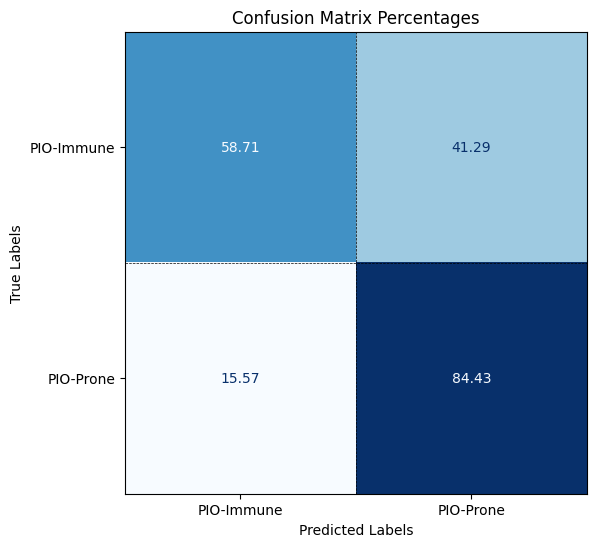

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert y_test to a DataFrame
df_test = pd.DataFrame({
    'y_test': y_test,
    'prone_or_immune': np.where(y_test > 100, 1, 0)
})

# Convert y_pred to a DataFrame
df_pred = pd.DataFrame({
    'y_pred': y_pred,
    'prone_or_immune': np.where(y_pred > 100, 1, 0)
})

# Compute the confusion matrix
cm = confusion_matrix(df_test['prone_or_immune'], df_pred['prone_or_immune'])

# Normalize the confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Define your custom labels
labels = ['PIO-Immune', 'PIO-Prone']

# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', values_format=".2f", ax=ax, colorbar=False)  # Show percentages

# Add gridlines only around the cells
ax.grid(False)  # Turn off the default gridlines
for i in range(cm.shape[0] + 1):
    ax.axhline(i - 0.5, color='black', linestyle='--', linewidth=0.5)  # Horizontal lines
    ax.axvline(i - 0.5, color='black', linestyle='--', linewidth=0.5)  # Vertical lines

# Set custom labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix Percentages')

# Show the plot
plt.show()



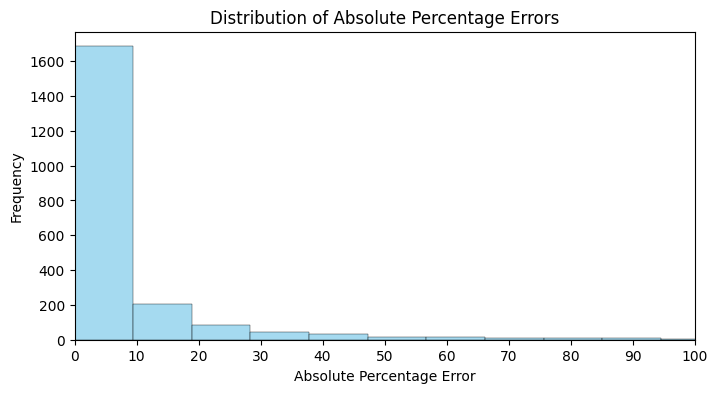

(330.6353798288819, 780.2005606619597)

In [40]:
absolute_errors = np.abs(y_test-y_pred)
percentage_errors = np.abs((y_test-y_pred)/y_test)
std_dev = np.std(absolute_errors)
mae = np.mean(absolute_errors)
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histogram of absolute errors
plt.figure(figsize=(8, 4))
sns.histplot(percentage_errors, bins=150, color='skyblue')
plt.xlabel("Absolute Percentage Error")
plt.ylabel("Frequency")
plt.xlim([0, 100])
# Generate and set more xticks
xticks = np.linspace(0, 100, 11)  # Generates 21 evenly spaced ticks from 0 to 100
plt.xticks(xticks)
plt.title("Distribution of Absolute Percentage Errors")
plt.show()
mae, std_dev


In [41]:
percentage_errors.max(), percentage_errors.min()

(1419.0761232974953, 0.0)

### sample predictions

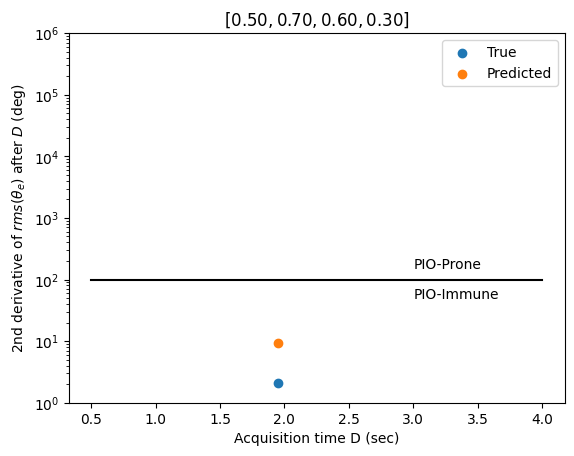

In [42]:
import random
index1 = int(random.uniform(0, len(y_test)))
index1
plt.scatter(D_test[index1], y_test[index1], label = 'True')
plt.scatter(D_test[index1], y_pred[index1], label = 'Predicted')
# PIO boundary and axis settings
PIO_prone = [100, 100]  # Boundary line for PIO-prone region
x_6 = [0.5, 4] #[0, 2.5]  # Corresponding x-axis range for PIO_prone
plt.text(3, 150, 'PIO-Prone')
plt.text(3, 50, 'PIO-Immune')
plt.plot(x_6, PIO_prone, 'k', linewidth=1.5)  # Boundary line
#plt.title('Neal-Smith PIO Parameter Plane Prediction Comparison')
label = r'$[{:.2f}, {:.2f}, {:.2f}, {:.2f}]$'.format(X_test[index1,0], X_test[index1,1], X_test[index1,2], X_test[index1,3]) 
plt.title(label)
#plt.grid(True)
#plt.xlabel('Acquisition time D (sec)\nNLDI (red)     Stick-to-Servo (blue)')
plt.xlabel('Acquisition time D (sec)')
plt.ylabel(r'2nd derivative of $rms(\theta_e)$ after $D$ (deg)')
plt.yscale('log')
plt.ylim([1,1000000])
plt.legend()
plt.show()

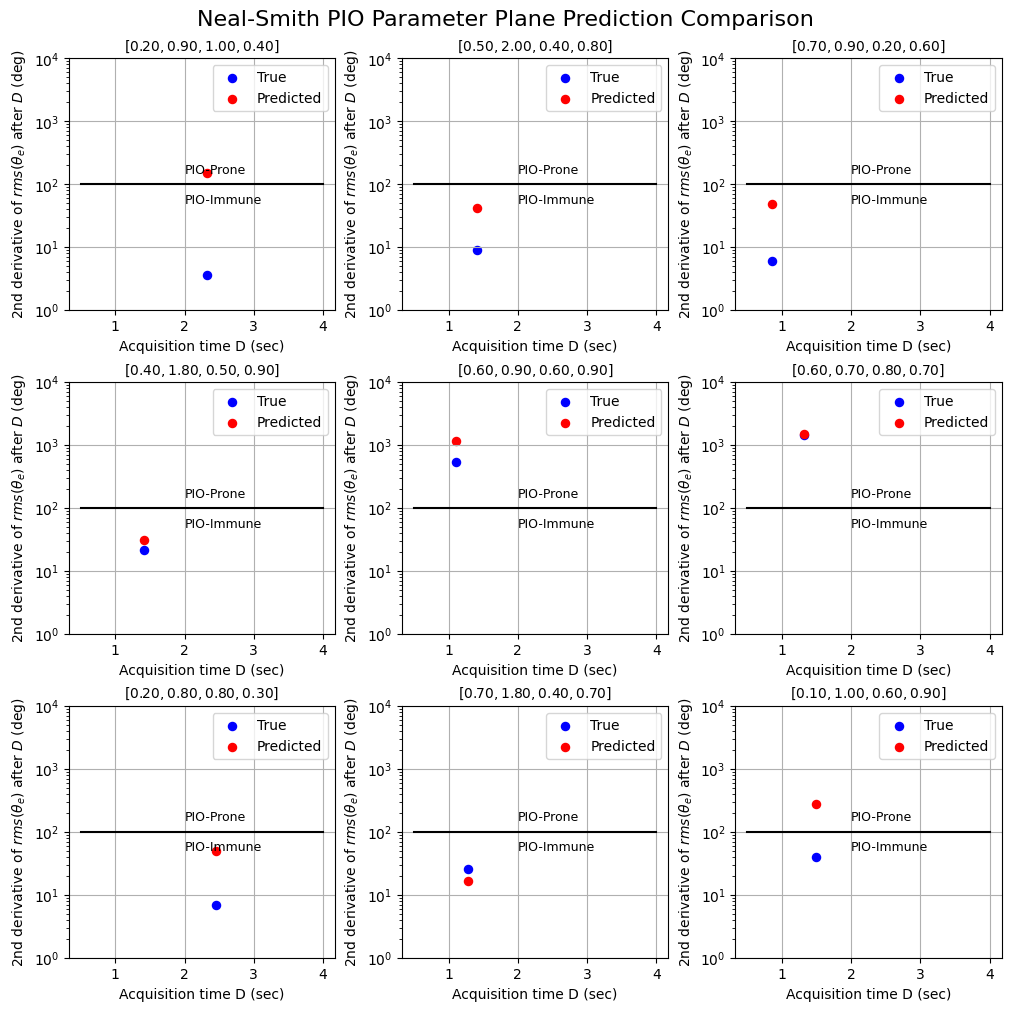

In [43]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Assuming D_test, y_test, y_pred, and X_test are defined
fig, axes = plt.subplots(3, 3, figsize=(10,10), constrained_layout=True)
fig.suptitle('Neal-Smith PIO Parameter Plane Prediction Comparison', fontsize=16)

# Loop to create subplots for 9 random indices
for i in range(3):
    for j in range(3):
        index = int(random.uniform(0, len(y_test)))
        
        # Scatter plots for True and Predicted values
        axes[i, j].scatter(D_test[index], y_test[index], label='True', color='blue',s=34 )
        axes[i, j].scatter(D_test[index], y_pred[index], label='Predicted', color='red', s=34)

        # PIO boundary and axis settings
        PIO_prone = [100, 100]  # Boundary line for PIO-prone region
        x_6 = [0.5, 4]  # Corresponding x-axis range for PIO_prone
        axes[i, j].plot(x_6, PIO_prone, 'k', linewidth=1.5)  # Boundary line

        # Add labels and grid
        label = r'$[{:.2f}, {:.2f}, {:.2f}, {:.2f}]$'.format(X_test[index, 0], X_test[index, 1], X_test[index, 2], X_test[index, 3])
        axes[i, j].set_title(label, fontsize=10)
        axes[i, j].set_xlabel('Acquisition time D (sec)')
        axes[i, j].set_ylabel(r'2nd derivative of $rms(\theta_e)$ after $D$ (deg)')
        axes[i, j].set_yscale('log')
        axes[i, j].set_ylim([1, 10000])
        axes[i, j].legend()
        axes[i, j].text(2, 150, 'PIO-Prone', fontsize=9)
        axes[i, j].text(2, 50, 'PIO-Immune', fontsize=9)
        axes[i, j].grid(True)

plt.show()


In [44]:
D_array_filtered.shape, pio_values_filtered.shape, params_filtered.shape, rmse_array_filtered.shape

((10936,), (10936,), (10936, 4), (10936,))

# flying qualities steps

In [45]:
import math
theta_pc_log = []
for i in range(len(D_array_filtered)):
    w_bw = 1/(D_array_filtered[i]) * math.log(1/40)
    theta_pc = (180/math.pi) * (math.atan(params_filtered[i,0]*w_bw) - math.atan(params_filtered[i,1]*w_bw))
    theta_pc_log.append(theta_pc)

np.array(theta_pc_log).shape


(10936,)

C:\Users\steph\AppData\Local\Temp\ipykernel_12112\488150136.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "xb" (-> color='b'). The keyword argument will take precedence.
  plt.plot(np.array(theta_pc_log)[i],rmse_array_filtered[i], 'xb', c = colors[np.random.randint(0, 5)])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


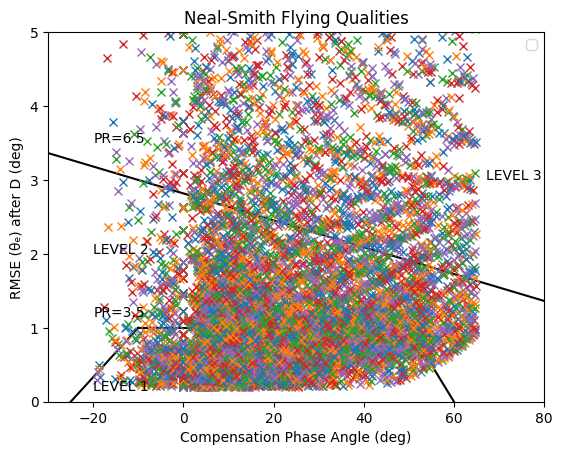

In [46]:
# Define the data
x_2 = np.arange(-25, -9)
y = (1/15) * x_2 + (5/3)

x_3 = [-10, 50]
q = [1, 1]

x_4 = np.arange(50, 61)
p = (-1/10) * x_4 + 6

#x_5 = [45, 100]
#r = [2, 1]
x_5 = np.linspace(-30, 80, 100) 
r = -0.01818181818181818 * x_5 + 2.818

PIO_prone = [100, 100]
x_6 = [1, 2.5]


# Create the plot
plt.figure()
plt.plot(x_2, y, 'k', linewidth=1.5)
plt.plot(x_3, q, 'k', linewidth=1.5)
plt.plot(x_4, p, 'k', linewidth=1.5)
plt.plot(x_5, r, 'k', linewidth=1.5)

# Add text annotations
plt.text(-20, min(q) + 0.15, 'PR=3.5')
#plt.text(min(x_5) - 15, max(r) + 0.15, 'PR=6.5')
plt.text(-20, 3.5, 'PR=6.5')
plt.text(-20, 0.15, 'LEVEL 1')
plt.text(-20, 2, 'LEVEL 2')
plt.text(67, 3, 'LEVEL 3')

for i in range(len(D_array_filtered)):
  plt.plot(np.array(theta_pc_log)[i],rmse_array_filtered[i], 'xb', c = colors[np.random.randint(0, 5)])

# Set plot title and labels
plt.title('Neal-Smith Flying Qualities')
#plt.grid(True)
plt.xlabel('Compensation Phase Angle (deg)', fontsize=10)
plt.ylabel('RMSE (θₑ) after D (deg)')
plt.xlim([-30, 80])
plt.ylim([0, 5])

# Plot Stick-to-Servo data points

#plt.plot(theta_pc_max, rmse_max, '*b', markersize=10, color = 'red', label = label)

#label = r'$T_{{Lead}}: {:.2f}, T_{{Lag}}: {:.2f}, \tau: {:.2f}, K_{{p}}: {:.2f}$'.format(tld_min, tlg_min, tau_min, kp_min)
#plt.plot(theta_pc_min, rmse_min, '*b', markersize=10, color = 'green', label = label)
#plt.plot(phase_ang2, RMSE2, 'ob', markersize=10)
#plt.plot(phase_ang3, RMSE3, '+b', markersize=10)
#plt.plot(phase_ang4, RMSE4, 'sb', markersize=10)
#plt.plot(phase_ang5, RMSE5, '^b', markersize=10)

plt.legend()

# Show the plot
plt.show()
